In this module, we embark on transfer learning for image processing. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shutil
import os
# import lucid

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.keras.utils import to_categorical

%matplotlib inline

In [2]:
path="C:\\Users\\gao\\GAO_Jupyter_Notebook\\Datasets"
os.chdir(path)

#### I. Overview on Transfer Learning

A **pretrained network** is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If the original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different classification tasks. This is true even when these new problems may involve completely different image classes than the original task. For example, we might train a network on ImageNet (where classes are mostly animals and everyday objects) and then repurpose this trained network for soemthing as remote as identifying furniture items in images. 

There are 2 ways of using pretrained network: **feature extraction** and **fine-tuning**. We will discuss both in detail. 

##### 1. Feature Extraction

Feature extraction consists of using the presentations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch. Remember convnets can be broken down into two parts: the 1st is the convolutional base of the model (a series of convolution layers with pooling layers). Feature extract consists of taking the convolutional base of a previously trained network, running the new data through it, and training a new classifier on top of the output. 

The rationale for feature extraction is that representations learned by the convolutional base are likely to be more generic and transferable and thus more reusable: the feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer-vision problem at hand. But the representations learned by the classifier (dense layers) will necessarily be specific to the set of classes on which the model was trained. They do not contain the notion of space, whereas the object location is still described by convolutional feature maps. For problems where object location matters, densely connected features are largely useless. 

Note that the level of generality of the representations extracted by specific convolution layers depends on the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual edges colors, and textures etc.), whereas layers that are higher up extract more-abstract concepts (such as 'cat ears'). So if the new dataset to be trained differed a lot from the original dataset on which the model was trained originally, we may be better off using only the few few layers of the model to do feature extract, rather than using the hentire convolutoinal base. 

There are many pretrained models we can use: for example, Xception, Inception V3. ResNet50, VGG16, VGG19, MobileNet etc. These come together with the Keras package. In general, there are two ways we can go about for feature extraction:

   1. We can run the convolutional base over our dataset, recording its output to a numpy.ndarray object on disk, and then using this data as input to a standalone, densely connected classifier. This solution is fast and cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the most expensive part of the pipeline. The downside of this is that we cannot use data augmentation. 
   2. We can extend the model (the convolutional base) by adding dense layers on top, and running the whole thing end to end on the input data. This will allow data augmentation, because every input image goes through the convolutional base every time it's seen by the model. But this is very compututationally expensive. This usually requires GPU. In addition, when we compile and train the model. it's important to freeze the convolutional base. Freezing the layers means preventing their weights from being updated during training. Failure to do this will result in the scenario in which representations previously learned by the convolutional base are modified (to do this, simply set _conv_base.trainable = False_ in Keras).

##### 2. Fine-tuning

Another widely used technique for transfer learning is fine-tuning, which consists of unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of hte model (in this case, the fully connected classifier) and these top layers. It's called fine-tuning because it slightly adjusts the more abstract representations of the model being reused, in order to make them more relevant for the problem at hand. When fine-tuning, it's always wise to use a low learning rate to avoid overfitting. Here is a visualization of fine-tuning the last few layers of the convolutional base:

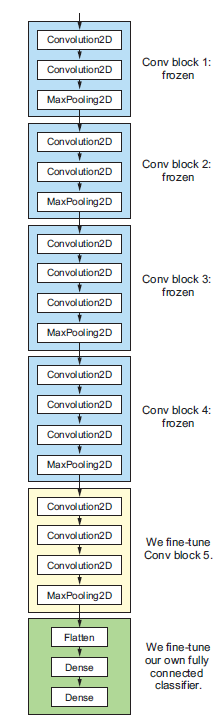

In [3]:
from IPython.display import Image
Image("fine_tuning VGG16.PNG", height=50, width=200)

#### II. Feature Extraction 

Let's consider a large convnet trained on the IMageNet dataset (1.4 million labeled images and 1000 different classes). ImageNet contains many animal classes, including different species of cats and dogs. We would expect to perform well on the dogs-vs-cats classification problem. In this example. we will use the VGG architecture developed in 2014. It's not the most recent developed model but it's a good benchmark model. 

In [4]:
conv_base=VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3)) # include_top=False ensures only downloading the convolutional base
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Notice that the final feature map has shape(4, 4, 512). This is hte feature on top of which we will stick a densely connected classifier. Let's now focus on the fast feature extraction without data augmentation method.

We will copy the code from the previous section (basically use existing data and folder structure):

   1. We create subfolders within the 'base_dir location': a folder for train, a folder for validation, and a folder for test.
   2. Within each subfolder (train, validation, test), we make more subfolders under them. For each of the three subfolders aforementioned, we create respective subfolders for cats and dogs.

In [5]:
base_dir = path+'\\dogs cats folder\\'  # this is the directory path where we can uncompress the data and place the files 
print(base_dir)
if os.path.isdir(base_dir): # if the directory already exists, then pass
    print('directory already exists')
    pass
else:
    os.mkdir(base_dir) # otherwise make a directory

C:\Users\gao\GAO_Jupyter_Notebook\Datasets\dogs cats folder\
directory already exists


In [6]:
train_dir = os.path.join(base_dir, 'train')
if os.path.isdir(train_dir):
    pass
else:
    os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if os.path.isdir(validation_dir):
    pass
else:
    os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if os.path.isdir(test_dir):
    pass
else:
    os.mkdir(test_dir)

print(train_dir)
print(test_dir)
print(validation_dir)

C:\Users\gao\GAO_Jupyter_Notebook\Datasets\dogs cats folder\train
C:\Users\gao\GAO_Jupyter_Notebook\Datasets\dogs cats folder\test
C:\Users\gao\GAO_Jupyter_Notebook\Datasets\dogs cats folder\validation


Now let's use ImageDataGenerator() to extract images as numpy arras as well as their labels:

In [30]:
datagen = ImageDataGenerator(rescale=1.0/255)
batch_size=20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator: # creating a generator object
        features_batch = conv_base.predict(inputs_batch) # predicting using the convolutional base
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000) # the sample_count parameter can exceed existing count
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


The extracted features are currently of shape (samples, 4, 4, 512). We will need to feed it to a densely connected classifier. So we must flatten it to (samples, 8192) because $4 \times 4 \times 512 = 8192$:

In [26]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

At this point, we can define our densely conneced classifier and train it on the data and labels we just recorded (we will be using 30 epochs for now):

In [29]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
              loss='binary_crossentropy', 
              metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 909us/sample - loss: 0.6129 - acc: 0.6630 - val_loss: 0.4493 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 1s 723us/sample - loss: 0.4357 - acc: 0.8075 - val_loss: 0.3704 - val_acc: 0.8480
Epoch 3/30
2000/2000 [==============================] - 1s 743us/sample - loss: 0.3653 - acc: 0.8380 - val_loss: 0.3296 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 2s 779us/sample - loss: 0.3249 - acc: 0.8675 - val_loss: 0.3058 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 2s 779us/sample - loss: 0.2966 - acc: 0.8780 - val_loss: 0.2902 - val_acc: 0.8870
Epoch 6/30
2000/2000 [==============================] - 2s 766us/sample - loss: 0.2752 - acc: 0.8900 - val_loss: 0.2804 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 2s 756us/sample - loss: 0.2499 - acc: 0.9035 - val_loss: 0.2660 - va

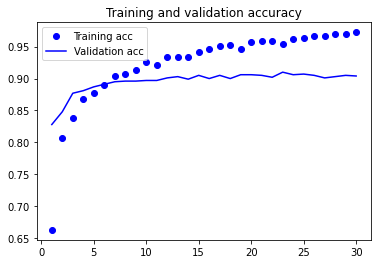

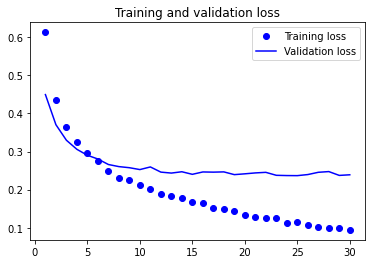

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We see that the validation accuracy is about 90%, which is above 83% from brute-force training of the model in the last section. But the plots also indicate that we are overfitting almost from the start, despite using dropout with a fairly large rate. This is because this technique doesn't use data augmentation, which is essential for preventing overfitting with small image datasets. 

Now let's look at feature extraction with data augmentation. This is an expensive technique. If computation allows, this is a better option than the first one certainly. 

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('Number of trainable weights before freezing the convolutional base: ', len(model.trainable_weights))
conv_base.trainable=False
print('Number of trainable weights after freezing the convolutional base: ', len(model.trainable_weights))

Number of trainable weights before freezing the convolutional base:  30
Number of trainable weights after freezing the convolutional base:  4


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              target_size=(150, 150),
                                                              batch_size=20,
                                                              class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/30
100/100 [==============================] - 224s 2s/step - loss: 0.6028 - acc: 0.6780 - val_loss: 0.4459 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 218s 2s/step - loss: 0.4801 - acc: 0.7900 - val_loss: 0.3634 - val_acc: 0.8620
Epoch 3/30
100/100 [==============================] - 216s 2s/step - loss: 0.4271 - acc: 0.8115 - val_loss: 0.3398 - val_acc: 0.8590
Epoch 4/30
100/100 [==============================] - 220s 2s/step - loss: 0.4010 - acc: 0.8230 - val_loss: 0.3170 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 220s 2s/step - loss: 0.3812 - acc: 0.8325 - val_loss: 0.2999 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 238s 2s/step - loss: 0.3817 

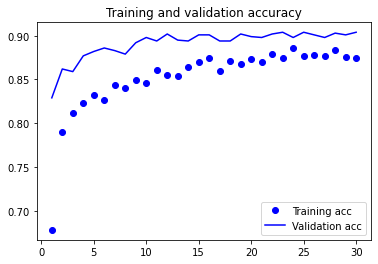

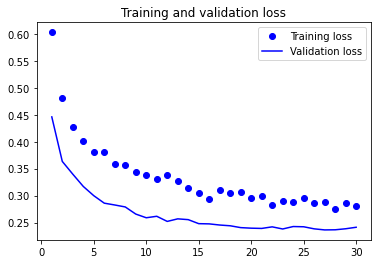

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
model.save('feature_extraction_cnn_example.h5')

#### III. Fine-tuning

Fine-tuning usually requires the following steps:
   1. Add your custom network on top of an already-trained base network (say VGG16).
   2. Freeze the base network.
   3. Train the part we added.
   4. Unfreeze some layers in teh base network.
   5. Jointly train both these layers and the part we added. 
   
   
Let's use the VGG16 as before for our convolutional base. Let's proceed with step 4. We will unfreeze our conv_base and then freeze individual layers inside it. Notice that VGG16 base has 5 convolutional layers. 

In [13]:
conv_base.trainable= True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable= False

In [15]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history2 = model.fit(train_generator, epochs=20, validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/20
100/100 [==============================] - 253s 3s/step - loss: 0.2649 - acc: 0.8870 - val_loss: 0.2030 - val_acc: 0.9220
Epoch 2/20
100/100 [==============================] - 252s 3s/step - loss: 0.2463 - acc: 0.9010 - val_loss: 0.2365 - val_acc: 0.9070
Epoch 3/20
100/100 [==============================] - 245s 2s/step - loss: 0.2228 - acc: 0.9030 - val_loss: 0.2109 - val_acc: 0.9180
Epoch 4/20
100/100 [==============================] - 273s 3s/step - loss: 0.2079 - acc: 0.9145 - val_loss: 0.1956 - val_acc: 0.9280
Epoch 5/20
100/100 [==============================] - 247s 2s/step - loss: 0.1951 - acc: 0.9220 - val_loss: 0.1992 - val_acc: 0.9230
Epoch 6/20
100/100 [==============================] - 247s 2s/step - loss: 0.1924 - acc: 0.9240 - val_loss: 0.1883 - val_acc: 0.9240
Epoch 7/20
100/100 [==============================] - 247s 2s/step - loss: 0.1736 - acc: 0.9345 - val_loss: 0

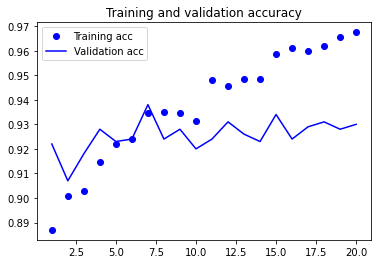

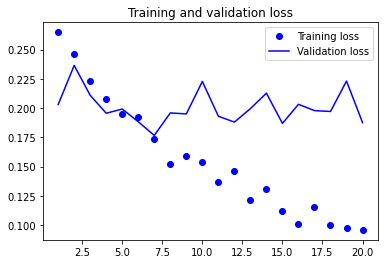

In [16]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [19]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=20, class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test accuarcy: ', test_acc)

Found 1000 images belonging to 2 classes.
  ...
    to  
  ['...']
50/50 [==============================] - 70s 1s/step - loss: 0.2004 - acc: 0.9340
test accuarcy:  0.934


#### References:

   - Goodfellow, Ian and Bengio, Yoshua and Courville, Aaron (2016). Deep Learning. MIT Press.
   - Chollet, Francois. Deep Learning with Python, 2018. Print.